now only fish/engine

In [1]:
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Function to preprocess a single file
def preprocess_file(file_path):
    df = pd.read_csv(file_path)
    
    # Filter for the two target statuses
    target_labels = ["Under way using engine", "Engaged in fishing"]
    df = df[df['Navigational status'].isin(target_labels)]
    
    # Skip files with no valid data
    if df.empty:
        return None, None
    
    # Subtract initial COG and adjust circular values
    initial_cog = df['COG'].iloc[0]
    df['COG'] = (df['COG'] - initial_cog) % 360
    df['Heading'] = (df['Heading'] - initial_cog) % 360
    
    # Cyclic encoding of circular values
    df['COG_sin'] = np.sin(np.deg2rad(df['COG']))
    df['COG_cos'] = np.cos(np.deg2rad(df['COG']))
    df['Heading_sin'] = np.sin(np.deg2rad(df['Heading']))
    df['Heading_cos'] = np.cos(np.deg2rad(df['Heading']))
    
    # Extract relevant features and target
    features = df[['SOG', 'COG_sin', 'COG_cos', 'Heading_sin', 'Heading_cos']].values
    target = df['Navigational status'].iloc[0]  # All rows in the file have the same status
    
    return features, target

# Load and preprocess all files
def load_data(data_folder):
    X, y = [], []
    for file_name in os.listdir(data_folder):
        file_path = os.path.join(data_folder, file_name)
        features, target = preprocess_file(file_path)
        if features is not None:
            X.append(features)
            y.append(target)
    
    # Encode target labels
    label_encoder = LabelEncoder()
    y = label_encoder.fit_transform(y)
    return np.array(X), np.array(y), label_encoder

# Build LSTM model
def build_model(input_shape):
    model = Sequential([
        LSTM(64, input_shape=input_shape, return_sequences=True),
        Dropout(0.2),
        LSTM(32),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Main script
if __name__ == "__main__":
    data_folder = "time_sets_standardized"
    X, y, label_encoder = load_data(data_folder)
    
    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    # Ensure consistent sequence length
    max_sequence_length = max([len(sequence) for sequence in X_train])
    X_train = tf.keras.preprocessing.sequence.pad_sequences(X_train, maxlen=max_sequence_length, dtype='float32', padding='post')
    X_test = tf.keras.preprocessing.sequence.pad_sequences(X_test, maxlen=max_sequence_length, dtype='float32', padding='post')
    
    # Build and train the model
    model = build_model((X_train.shape[1], X_train.shape[2]))
    model.summary()
    history = model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)
    
    # Evaluate the model
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")
    
    # Save the model and label encoder
    model.save("vessel_navigational_status_model.h5")
    with open("label_encoder.pkl", "wb") as f:
        import pickle
        pickle.dump(label_encoder, f)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 90, 64)            17920     
                                                                 
 dropout (Dropout)           (None, 90, 64)            0         
                                                                 
 lstm_1 (LSTM)               (None, 32)                12416     
                                                                 
 dropout_1 (Dropout)         (None, 32)                0         
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 30,881
Trainable params: 30,881
Non-traina

78/78 [==============================] - 1s 8ms/step
F1 Score: 0.8539


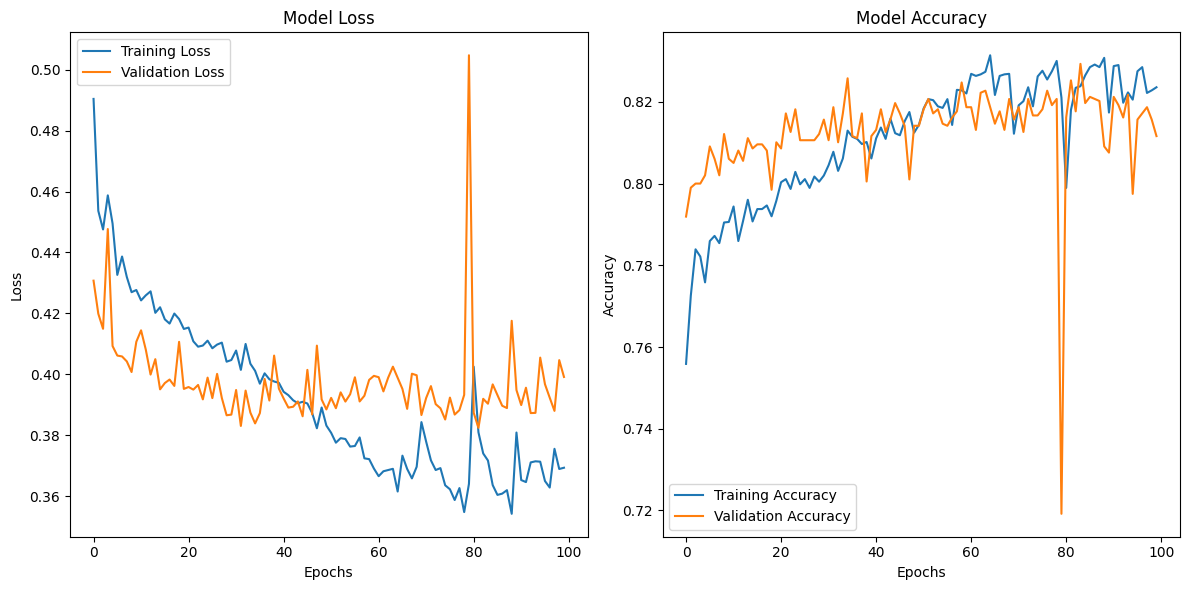

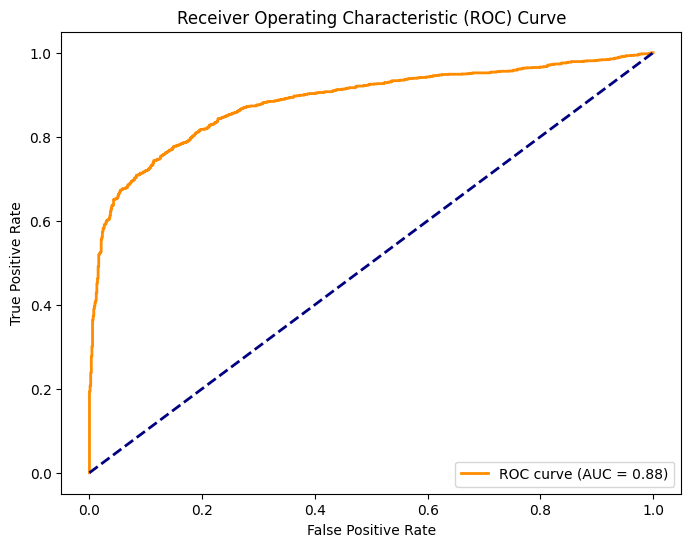

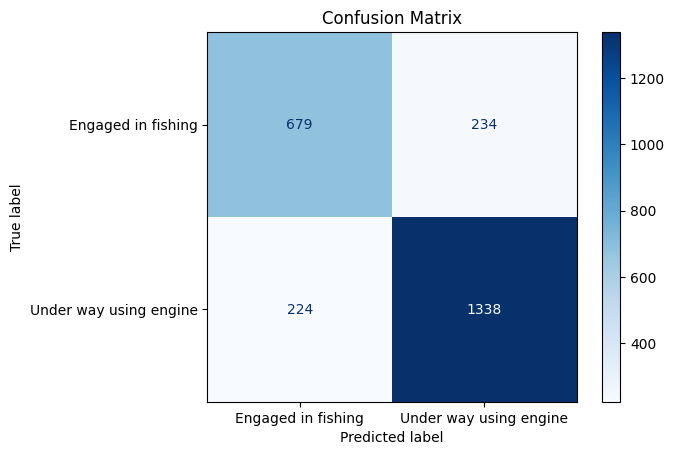

Test Accuracy: 0.8149


In [2]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, f1_score, confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

# Evaluate the model on training data for learning curve
# history = model.fit(X_train, y_train, validation_split=0.2, epochs=20, batch_size=32, verbose=1)

# Plot Learning Curve (Loss and Accuracy)
def plot_learning_curve(history):
    # Plot training & validation loss values
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training & validation accuracy values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot ROC Curve
def plot_roc_curve(y_true, y_pred_probs):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

# Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

# Main Evaluation Script
if __name__ == "__main__":
    # Make predictions on test set
    y_pred_probs = model.predict(X_test)  # Predicted probabilities
    y_pred = (y_pred_probs > 0.5).astype("int32")  # Predicted classes (threshold 0.5)

    # F1 Score
    f1 = f1_score(y_test, y_pred)
    print(f"F1 Score: {f1:.4f}")

    # Learning Curve Plot
    plot_learning_curve(history)

    # ROC Curve Plot
    plot_roc_curve(y_test, y_pred_probs)

    # Confusion Matrix Plot
    plot_confusion_matrix(y_test, y_pred)
    
    # Optional: Accuracy Score
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {accuracy:.4f}")
